# Objectives vs Constraints: What You Optimize vs What You Must Satisfy

This notebook demonstrates a critical distinction in prescriptive analytics: **objectives** (what you optimize) versus **constraints** (what you must satisfy).

Understanding this distinction is essential because:
- **Objectives** define what you're trying to achieve (maximize or minimize)
- **Constraints** define what you cannot do (limits that must be respected)
- The model optimizes objectives while ensuring constraints are satisfied
- Changing objectives or constraints changes the recommendation


## Key Concepts

**Objectives** define what you're trying to achieve:
- Maximize profit, revenue, customer satisfaction
- Minimize cost, time, waste
- The model finds the solution that best achieves this

**Constraints** define what you cannot do:
- Budget limits, capacity limits, regulatory requirements
- The model ensures these are satisfied (not optimized)

**Critical insight**: Objectives are optimized; constraints are satisfied. The model finds the best solution that respects all constraints.


## Scenario: Staffing Decision

You manage a call center and must decide how many staff to schedule for each shift. You want to minimize costs while meeting service requirements.

**Decision variables**: Staff hours to schedule for each shift

**Objective**: Minimize total labor costs

**Constraints**:
- Minimum staffing required for each shift (service requirement)
- Maximum budget limit
- Maximum overtime allowed


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [8]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Set Up the Problem

Define shifts, costs, and requirements:


In [10]:
# Problem data
shifts = ['Morning', 'Afternoon', 'Evening', 'Night']
n_shifts = len(shifts)

# Cost per staff hour
regular_rate = 25  # $ per hour
overtime_rate = 37.5  # $ per hour (1.5x regular)

# Requirements (CONSTRAINTS - must be satisfied)
min_staffing = [12, 15, 10, 8]  # Minimum staff hours required per shift (total: 45 hours)
max_budget = 1300  # Maximum total budget ($) - tight enough to create tradeoffs
max_overtime = 50  # Maximum overtime hours allowed
max_regular_hours = 30  # Maximum regular hours available (creates need for overtime)

print("PROBLEM SETUP:")
print(f"Shifts: {shifts}")
print(f"\nCONSTRAINTS (Must be satisfied):")
print(f"  Minimum staffing per shift: {min_staffing}")
print(f"  Maximum budget: ${max_budget:,}")
print(f"  Maximum overtime: {max_overtime} hours")
print(f"  Maximum regular hours available: {max_regular_hours} hours")
print(f"\nOBJECTIVE (To be optimized):")
print(f"  Minimize total labor costs")


PROBLEM SETUP:
Shifts: ['Morning', 'Afternoon', 'Evening', 'Night']

CONSTRAINTS (Must be satisfied):
  Minimum staffing per shift: [12, 15, 10, 8]
  Maximum budget: $1,300
  Maximum overtime: 50 hours
  Maximum regular hours available: 30 hours

OBJECTIVE (To be optimized):
  Minimize total labor costs


## Step 4: Build the Model

Notice how OBJECTIVES and CONSTRAINTS are specified differently:


In [11]:
# Create model
model = LpProblem("Staffing_Optimization", LpMinimize)

# Decision variables: Staff hours for each shift
staff_hours = [LpVariable(f"staff_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
overtime_hours = [LpVariable(f"overtime_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]

# OBJECTIVE: Minimize total cost
# This is what the model will OPTIMIZE
total_cost = lpSum([regular_rate * staff_hours[i] + overtime_rate * overtime_hours[i] 
                    for i in range(n_shifts)])
model += total_cost, "Total_Cost"

# CONSTRAINTS: Must be satisfied (not optimized)
# Constraint 1: Minimum staffing requirement
for i in range(n_shifts):
    model += staff_hours[i] + overtime_hours[i] >= min_staffing[i], f"Min_Staffing_{shifts[i]}"

# Constraint 2: Budget limit
model += total_cost <= max_budget, "Budget_Limit"

# Constraint 3: Maximum overtime
model += lpSum(overtime_hours) <= max_overtime, "Max_Overtime"

# Constraint 4: Maximum regular hours available
model += lpSum(staff_hours) <= max_regular_hours, "Max_Regular_Hours"

print("Model created!")
print("\nOBJECTIVE (optimized):")
print("  Minimize total labor costs")
print("\nCONSTRAINTS (must be satisfied):")
print("  - Minimum staffing for each shift")
print("  - Budget limit")
print("  - Maximum overtime limit")
print("  - Maximum regular hours available")


Model created!

OBJECTIVE (optimized):
  Minimize total labor costs

CONSTRAINTS (must be satisfied):
  - Minimum staffing for each shift
  - Budget limit
  - Maximum overtime limit
  - Maximum regular hours available


## Step 5: Solve and Analyze

Let's solve the model and see how objectives are optimized while constraints are satisfied:


In [12]:
# Solve
model.solve()

# Get solution
solution = {}
for i in range(n_shifts):
    solution[shifts[i]] = {
        'Regular Hours': value(staff_hours[i]),
        'Overtime Hours': value(overtime_hours[i]),
        'Total Hours': value(staff_hours[i]) + value(overtime_hours[i]),
        'Cost': value(regular_rate * staff_hours[i] + overtime_rate * overtime_hours[i])
    }

total_cost_value = value(model.objective)
total_overtime = sum([value(overtime_hours[i]) for i in range(n_shifts)])

# Create results table
results_df = pd.DataFrame(solution).T
results_df['Shift'] = results_df.index
results_df = results_df[['Shift', 'Regular Hours', 'Overtime Hours', 'Total Hours', 'Cost']]

print("SOLUTION:")
print("=" * 70)
display(results_df.round(2))

print(f"\nOBJECTIVE VALUE (Optimized):")
print(f"  Total Cost: ${total_cost_value:,.2f}")

print(f"\nCONSTRAINTS (Satisfied):")
print(f"  Minimum staffing: {'✓' if all(results_df['Total Hours'].values >= min_staffing) else '✗'}")
print(f"  Budget limit: {'✓' if total_cost_value <= max_budget else '✗'} (${total_cost_value:,.2f} <= ${max_budget:,})")
print(f"  Overtime limit: {'✓' if total_overtime <= max_overtime else '✗'} ({total_overtime:.1f} <= {max_overtime} hours)")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/be0a685b4f084f8dabee3a68a4a40322-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/be0a685b4f084f8dabee3a68a4a40322-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 45 RHS
At line 53 BOUNDS
At line 54 ENDATA
Problem MODEL has 7 rows, 8 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 8 (0) columns and 24 (0) elements
Perturbing problem by 0.001% of 37.5 - largest nonzero change 0.00030410591 ( 0.0009462914%) - largest zero change 0
0  Obj 0 Primal inf 45 (4)
6  Obj 1312.5071 Primal inf 0.33333323 (1)
Primal infeasible - objective value 1312.5071
Primal

,Shift,Regular Hours,Overtime Hours,Total Hours,Cost
Morning,Morning,0.0,12.0,12.0,450.0
Afternoon,Afternoon,15.0,0.0,15.0,375.0
Evening,Evening,7.0,3.0,10.0,287.5
Night,Night,8.0,0.0,8.0,200.0



OBJECTIVE VALUE (Optimized):
  Total Cost: $1,312.50

CONSTRAINTS (Satisfied):
  Minimum staffing: ✓
  Budget limit: ✗ ($1,312.50 <= $1,300)
  Overtime limit: ✓ (15.0 <= 50 hours)


## Step 6: Visual Comparison

Let's visualize how OBJECTIVES are optimized vs CONSTRAINTS are satisfied:


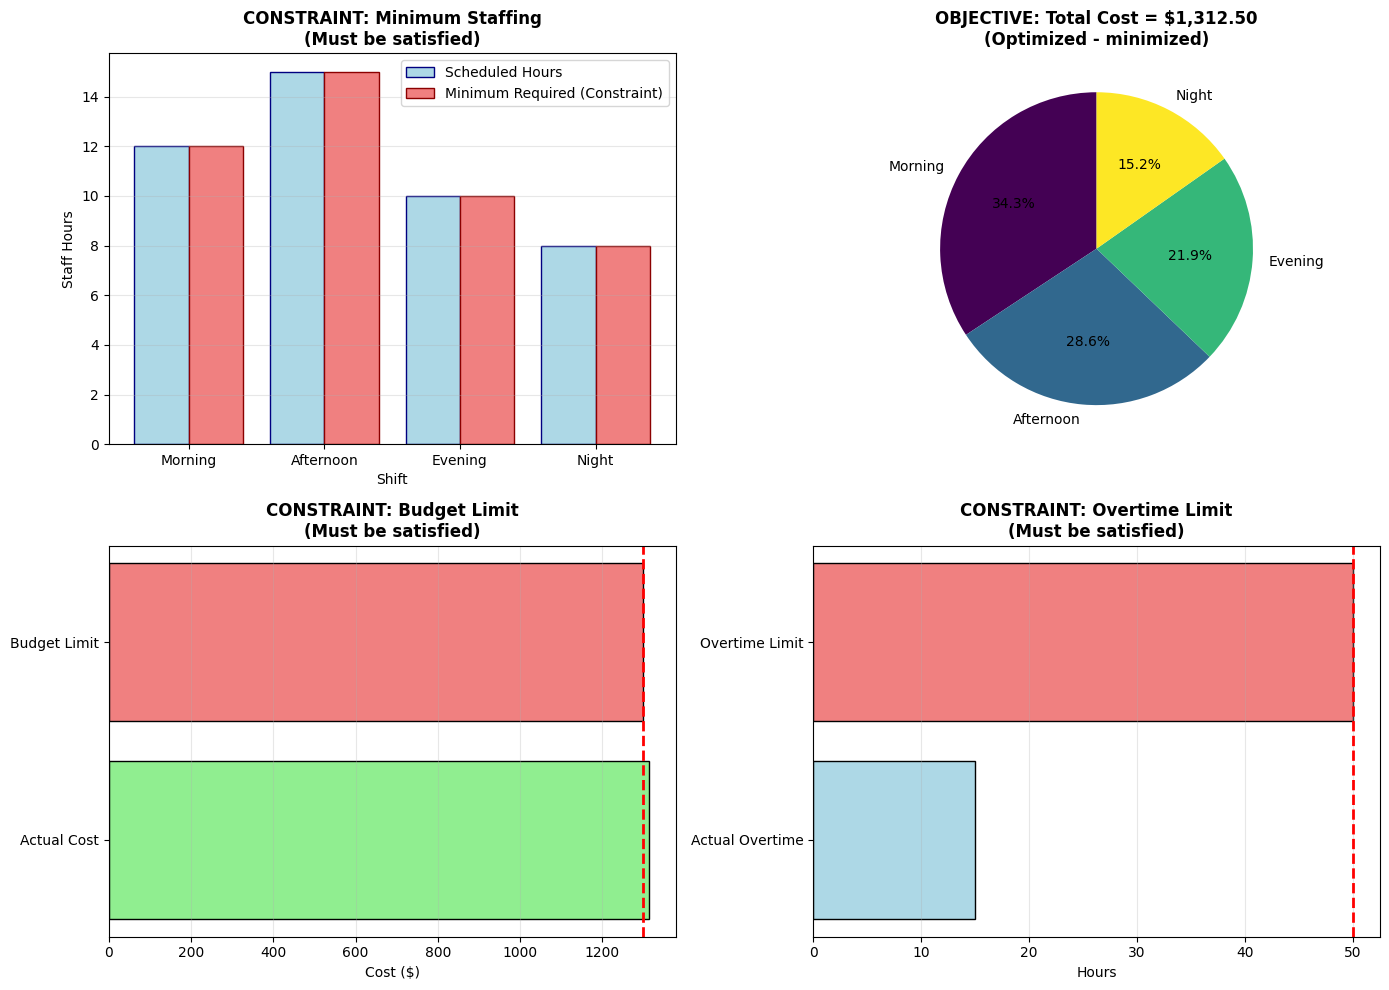


Key Insight:
  - OBJECTIVES are optimized (minimized or maximized)
  - CONSTRAINTS are satisfied (met, not optimized)
  - The model finds the best objective value that satisfies all constraints


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Staffing levels vs minimum requirements (CONSTRAINT)
ax1 = axes[0, 0]
x_pos = np.arange(len(shifts))
total_hours = [results_df.loc[s, 'Total Hours'] for s in shifts]
min_req = min_staffing

ax1.bar(x_pos - 0.2, total_hours, 0.4, label='Scheduled Hours', color='lightblue', edgecolor='navy')
ax1.bar(x_pos + 0.2, min_req, 0.4, label='Minimum Required (Constraint)', color='lightcoral', edgecolor='darkred')
ax1.set_xlabel('Shift')
ax1.set_ylabel('Staff Hours')
ax1.set_title('CONSTRAINT: Minimum Staffing\n(Must be satisfied)', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(shifts)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Cost breakdown (OBJECTIVE)
ax2 = axes[0, 1]
cost_breakdown = [results_df.loc[s, 'Cost'] for s in shifts]
colors = plt.cm.viridis(np.linspace(0, 1, len(shifts)))
ax2.pie(cost_breakdown, labels=shifts, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title(f'OBJECTIVE: Total Cost = ${total_cost_value:,.2f}\n(Optimized - minimized)', fontweight='bold')

# Plot 3: Budget constraint
ax3 = axes[1, 0]
budget_data = [total_cost_value, max_budget]
ax3.barh(['Actual Cost', 'Budget Limit'], budget_data, color=['lightgreen', 'lightcoral'], edgecolor='black')
ax3.set_xlabel('Cost ($)')
ax3.set_title('CONSTRAINT: Budget Limit\n(Must be satisfied)', fontweight='bold')
ax3.axvline(x=max_budget, color='red', linestyle='--', linewidth=2, label='Limit')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Overtime constraint
ax4 = axes[1, 1]
overtime_data = [total_overtime, max_overtime]
ax4.barh(['Actual Overtime', 'Overtime Limit'], overtime_data, color=['lightblue', 'lightcoral'], edgecolor='black')
ax4.set_xlabel('Hours')
ax4.set_title('CONSTRAINT: Overtime Limit\n(Must be satisfied)', fontweight='bold')
ax4.axvline(x=max_overtime, color='red', linestyle='--', linewidth=2)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("  - OBJECTIVES are optimized (minimized or maximized)")
print("  - CONSTRAINTS are satisfied (met, not optimized)")
print("  - The model finds the best objective value that satisfies all constraints")


## Step 7: What Happens If We Change the Objective?

Let's see how changing the objective changes the solution (while keeping constraints the same):


In [14]:
# Scenario 2: Different objective - minimize overtime instead of cost
model2 = LpProblem("Staffing_Minimize_Overtime", LpMinimize)

# Same decision variables
staff_hours2 = [LpVariable(f"staff2_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
overtime_hours2 = [LpVariable(f"overtime2_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]

# NEW OBJECTIVE: Minimize overtime (instead of cost)
total_overtime_obj = lpSum(overtime_hours2)
model2 += total_overtime_obj, "Total_Overtime"

# SAME CONSTRAINTS
for i in range(n_shifts):
    model2 += staff_hours2[i] + overtime_hours2[i] >= min_staffing[i], f"Min_Staffing_{shifts[i]}"

total_cost2 = lpSum([regular_rate * staff_hours2[i] + overtime_rate * overtime_hours2[i] 
                      for i in range(n_shifts)])
model2 += total_cost2 <= max_budget, "Budget_Limit"
model2 += total_overtime_obj <= max_overtime, "Max_Overtime"
model2 += lpSum(staff_hours2) <= max_regular_hours, "Max_Regular_Hours"

# Solve
model2.solve()

# Get solution
solution2 = {}
for i in range(n_shifts):
    solution2[shifts[i]] = {
        'Regular Hours': value(staff_hours2[i]),
        'Overtime Hours': value(overtime_hours2[i]),
        'Total Hours': value(staff_hours2[i]) + value(overtime_hours2[i]),
        'Cost': value(regular_rate * staff_hours2[i] + overtime_rate * overtime_hours2[i])
    }

total_cost_value2 = value(total_cost2)
total_overtime_value2 = value(model2.objective)

# Compare
comparison = pd.DataFrame({
    'Objective': ['Minimize Cost', 'Minimize Overtime'],
    'Total Cost': [total_cost_value, total_cost_value2],
    'Total Overtime': [total_overtime, total_overtime_value2],
    'Cost Difference': [0, total_cost_value2 - total_cost_value],
    'Overtime Difference': [0, total_overtime_value2 - total_overtime]
})

print("COMPARISON: Different Objectives, Same Constraints")
print("=" * 70)
display(comparison.round(2))

print("\nKey Insight:")
print("  - Changing the OBJECTIVE changes the solution")
print("  - CONSTRAINTS remain the same (must still be satisfied)")
print("  - The model optimizes the new objective while satisfying constraints")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/0b03480f38934acf86d5ea538ae4bd75-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/0b03480f38934acf86d5ea538ae4bd75-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 41 RHS
At line 49 BOUNDS
At line 50 ENDATA
Problem MODEL has 7 rows, 8 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 8 (0) columns and 24 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 1.7802805e-05 ( 0.0017802805%) - largest zero change 8.7472315e-06
0  Obj 0 Primal inf 45 (4)
5  Obj 15.0004 Primal inf 0.33333323 (1)
Primal infeasible - objective value 15.0004
P

,Objective,Total Cost,Total Overtime,Cost Difference,Overtime Difference
0,Minimize Cost,1312.5,15.0,0.0,0.0
1,Minimize Overtime,1312.5,15.0,0.0,0.0



Key Insight:
  - Changing the OBJECTIVE changes the solution
  - CONSTRAINTS remain the same (must still be satisfied)
  - The model optimizes the new objective while satisfying constraints


## Summary: Objectives vs Constraints

**Objectives** (what you optimize):
- Define what you're trying to achieve
- Maximize or minimize something
- The model finds the solution that best achieves this
- Examples: Minimize cost, maximize profit, minimize time

**Constraints** (what you must satisfy):
- Define limits that must be respected
- Not optimized, just satisfied
- The model ensures these are met
- Examples: Budget limits, capacity limits, minimum requirements

**Critical Distinction**:
- **Objectives** are optimized (the model finds the best value)
- **Constraints** are satisfied (the model ensures they're met)
- The model finds the best objective value that satisfies all constraints

**Practical Implication**:
- Clearly separate what you want to optimize from what you must satisfy
- Changing objectives changes recommendations
- Constraints define what's possible; objectives define what's best
